In [26]:
import wandb, numpy as np, pandas as pd

api = wandb.Api()
PROJECT = "marawan-gamal/mnist-mtp"
KEY = "val/loss"

rows = []

for run in api.runs(PROJECT):
    vals = []
    for row in run.scan_history(keys=[KEY], page_size=10000):
        v = row.get(KEY)
        if isinstance(v, (int, float)):
            vals.append(float(v))
        elif isinstance(v, str):
            try:
                vals.append(float(v))
            except ValueError:
                pass
    min_val = np.min(vals) if vals else float("nan")
    rows.append({
        "model": run.config["model"],
        "pos_func": run.config["pos_func"],
        "rank": run.config["rank"],
        "val/loss": min_val,
    })

df = pd.DataFrame(rows)
print(df)


   model pos_func  rank  val/loss
0     cp      abs    10  0.218586
1    mps      abs    10  0.144189
2    moe      abs    10  0.203258
3     cp      abs    10  0.222638
4     cp   square    10       NaN
5    moe   square    10       NaN
6     cp      exp    10       NaN
7     cp  sigmoid    10       NaN
8    moe   square    64       NaN
9     cp  sigmoid    64       NaN
10    cp      exp    64       NaN
11    cp   square    64       NaN
12   moe  sigmoid    10       NaN
13   moe      exp    10       NaN
14    cp   square    10       NaN
15   moe      exp    64       NaN
16   moe  sigmoid    64       NaN


<Figure size 1000x500 with 0 Axes>

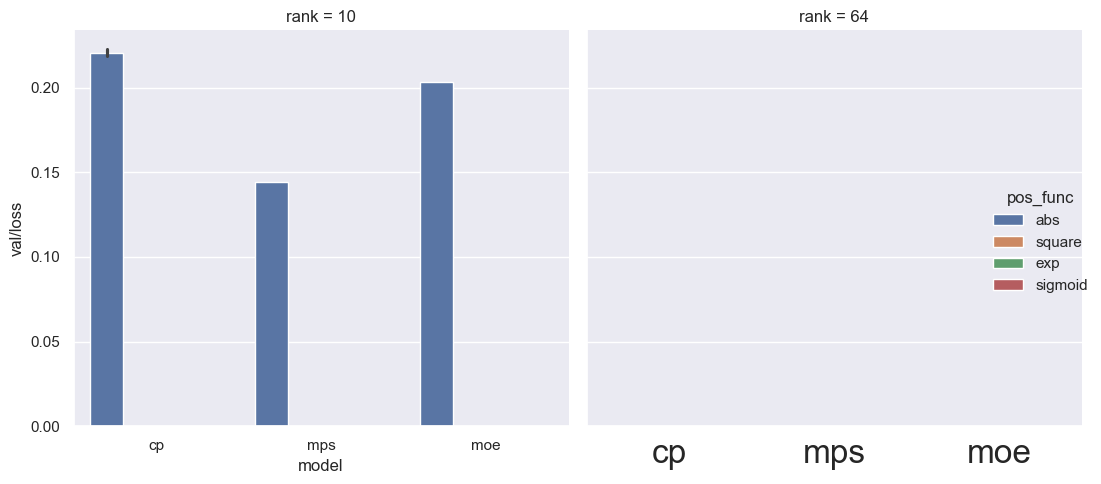

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
g = sns.catplot(
    data=df, 
    x="model",
    y="val/loss", 
    hue="pos_func", 
    col="rank", 
    # col_wrap=3, 
    kind="bar"
)
# g._legend.remove()
plt.ylabel(r"$\min \, \mathcal{L}_{\mathrm{eval}}$", fontsize=24)
plt.xlabel("")
plt.xticks(fontsize=24)
plt.yticks(fontsize=18)
# plt.legend(fontsize=24, title_fontsize=24, loc='upper left', bbox_to_anchor=(1,1))
# plt.legend([], [], frameon=False)
plt.tight_layout(); plt.show()

In [4]:
pd.DataFrame(rows)

,lr,rank,model,epochs,pos_func,batch_size,max_samples,num_gen_images,val/loss
0,0.001,10,cp,5,abs,32,None,10,NaN
1,0.001,10,mps,5,abs,32,None,10,NaN
2,0.001,10,moe,5,abs,32,None,10,NaN
